In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

from os import listdir
from os.path import isfile, join
import os.path
import random
import scipy.special as sp

from edward.models import Poisson,Gamma

plt.style.use('ggplot')

In [2]:
X = np.loadtxt('./pre_processed_data/bibtex/X_train.txt',delimiter=',')
Y = np.loadtxt('./pre_processed_data/bibtex/Y_train.txt',delimiter=',')
x_train_mask = np.loadtxt('./pre_processed_data/bibtex/x_train_mask.txt')
y_train_mask = np.loadtxt('./pre_processed_data/bibtex/y_train_mask.txt')
x = X*x_train_mask
y = Y*y_train_mask
tot = 101

mae_val = np.zeros(11)

In [3]:
def mae(t,result,result1):
    error = 0.0
    
    count = 0.0
    for i in range(0,users):
        for j in range(0,items1):
            if x_train_mask[i,j] == 0:
                error += abs(X[i,j]-result[i,j])
                count += 1
    error /= count
    #error = math.sqrt(error)
    
    error1 = 0.0
    count = 0
    for i in range(0,users):
        for j in range(0,items2):
            if y_train_mask[i,j] == 0:
                error1 += abs(Y[i,j]-result1[i,j])
                count += 1
    error1 /= count
    #error = math.sqrt(error)
    mae_val[t] = error+error1

In [4]:
def check(t):
    q_theta = Gamma(gam_shp,gam_rte)
    q_beta1 = Gamma(lam_shp,lam_rte)
    q_beta2 = Gamma(mu_shp,mu_rte)
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    init.run()
    no_sample = 100
    beta1_sample = q_beta1.sample(no_sample).eval()
    beta2_sample = q_beta2.sample(no_sample).eval()
    theta_sample = q_theta.sample(no_sample).eval()

    result1 = np.zeros([users,items1])
    result2 = np.zeros([users,items2])

    for i in range(0,no_sample):
        result1 = np.add(result1,np.matmul(theta_sample[i],np.transpose(beta1_sample[i])))
        result2 = np.add(result2,np.matmul(theta_sample[i],np.transpose(beta2_sample[i])))

    result1 /= no_sample
    result2 /= no_sample
    mae(t,result1,result2)

In [5]:
K = 5
users = X.shape[0]
items1 = X.shape[1]
items2 = Y.shape[1]
a = a_c = c = c_c = 0.3
b_c = d_c = 1.0

In [6]:
kappa_shp =  np.random.uniform(low=0.1,size=users)
kappa_rte = np.random.uniform(low=0.1,size=users)

tau_shp = np.random.uniform(low=0.1,size=items1)
tau_rte = np.random.uniform(low=0.1,size=items1)

rho_shp = np.random.uniform(low=0.1,size=items2)
rho_rte = np.random.uniform(low=0.1,size=items2)

phi = np.zeros([users,items1,K])
ohm = np.zeros([users,items2,K])

gam_shp = np.random.uniform(low=0.1,size=[users,K])
gam_rte = np.random.uniform(low=0.1,size=[users,K])

lam_shp = np.random.uniform(low=0.1,size=[items1,K])
lam_rte = np.random.uniform(low=0.1,size=[items1,K])

mu_shp = np.random.uniform(low=0.1,size=[items2,K])
mu_rte = np.random.uniform(low=0.1,size=[items2,K])

In [7]:
for u in range(0,users):
    kappa_shp[u] = a_c + K*a
for i in range(0,items1):
    tau_shp[i] = c_c + K*c
for j in range(0,items2):
    rho_shp[j] = c_c + K*c

for ite in range(0,tot):
    if ite%5==0:
        print(ite)
    
    for u in range(0,users):
        for i in range(0,items1):
            if x[u,i] > 0:
                phi[u,i,:]= np.exp(sp.digamma(gam_shp[u,:])-np.log(gam_rte[u,:])+sp.digamma(lam_shp[i,:])-np.log(lam_rte[i,:]))
                norm = np.sum(phi[u,i,:])
                phi[u,i,:] = phi[u,i,:]/norm
        for j in range(0,items2):
            if y[u,j] > 0:
                ohm[u,j,:]= np.exp(sp.digamma(gam_shp[u,:])-np.log(gam_rte[u,:])+sp.digamma(mu_shp[j,:])-np.log(mu_rte[j,:]))
                norm = np.sum(ohm[u,j,:])
                ohm[u,j,:] = ohm[u,j,:]/norm
    
    
    for u in range(0,users):
        for k in range(0,K):
            gam_shp[u,k] = a + np.inner(x[u,:],phi[u,:,k]) + np.inner(y[u,:],ohm[u,:,k])
            gam_rte[u,k] = (kappa_shp[u]/kappa_rte[u]) + np.sum(lam_shp[:,k]/lam_rte[:,k]) + np.sum(mu_shp[:,k]/mu_rte[:,k])
        kappa_rte[u] = (a_c/b_c) + np.sum(gam_shp[u,:]/gam_rte[u,:])
    
    for i in range(0,items1):
        for k in range(0,K):
            lam_shp[i,k] = c + np.inner(x[:,i],phi[:,i,k])
            lam_rte[i,k] = (tau_shp[i]/tau_rte[i]) + np.sum(gam_shp[:,k]/gam_rte[:,k])
        tau_rte[i] = (c_c/d_c) + np.sum(lam_shp[i,:]/lam_rte[i,:])
    
    for j in range(0,items2):
        for k in range(0,K):
            mu_shp[j,k] = c + np.inner(y[:,j],ohm[:,j,k])
            mu_rte[j,k] = (rho_shp[j]/rho_rte[j]) + np.sum(gam_shp[:,k]/gam_rte[:,k])
        rho_rte[j] = (c_c/d_c) + np.sum(mu_shp[j,:]/mu_rte[j,:])
        
    if ite%10 == 0:
        check(int(ite/10))

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


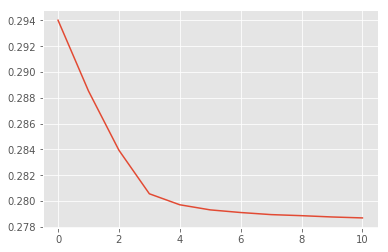

In [8]:
plt.plot(mae_val)
plt.show()
np.savetxt("mae_d_k05.txt",mae_val)